## Importing the CIFAR-100 dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import LabelBinarizer
# To ignore random tensorflow warnings.
import absl.logging
import matplotlib.pyplot as plt
absl.logging.set_verbosity(absl.logging.ERROR)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


## Data Augmentation

In [2]:
from keras.models import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

data_augment = Sequential([
    # Commented out when applying to testt data, because it's not deactivated at inference time
    # Rescaling(1./255),
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

enc = LabelBinarizer()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)
#x_train, y_train = np.concatenate((x_train, x_train), axis=0), np.concatenate((y_train, y_train), axis=0)

print(x_train.shape)

(50000, 32, 32, 3)


In [3]:
# For reference
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
          'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
          'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur',
          'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
          'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
          'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
          'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
          'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
          'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
          'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [4]:

def show_transformed_images(image_id, grid_size=(3, 3)):
    digit_y = enc.inverse_transform(y_train)
    fig, axes = plt.subplots(*grid_size, figsize=(3*grid_size[0], 3*grid_size[1]))
    label_idx = digit_y[image_id]

    axes.ravel()[0].imshow(x_train[image_id])
    axes.ravel()[0].set_xlabel('Original - ' + labels[label_idx])

    for axis in axes.ravel()[1:]:
        axis.imshow(data_augment(x_train[image_id]))

    fig.tight_layout()
    fig.show()

In [ ]:
import random

for _ in range(3):
    show_transformed_images(random.randint(0, 50000), (4, 4))

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


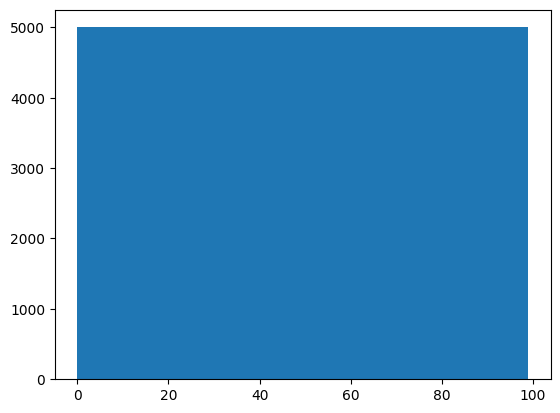

In [28]:
fig = plt.subplot()

fig.hist(digit_y)
# The distribtion of classes in the training data set seems to be uniform.
fig.plot()

distribution = []

# Let's check that with the raw numbers. It seems to be correct
for i in range(100):
    distribution.append((np.count_nonzero(digit_y == i)))

print(distribution)

In [5]:
!pip install pyNVML
import pynvml as nvidia_smi

def get_max_batch_size(model, image_size, inference=False):
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    total_gpu_memory = info.total
    # Weights are float32 -> 4 bytes
    model_size = model.count_params() * 4
    # Rescaling layer returns float32
    # RGB channels
    image_bytes = 4 * image_size * image_size * 3
    if inference:
        MAX_BATCH_SIZE = int(np.floor((total_gpu_memory - model_size) / image_bytes))
    else:
        MAX_BATCH_SIZE = int(np.floor(total_gpu_memory / (model_size + image_bytes)))
    MAX_BATCH_SIZE_LOG2 = int(2 ** np.floor(np.log2(MAX_BATCH_SIZE)))
    
    return MAX_BATCH_SIZE, MAX_BATCH_SIZE_LOG2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./models/colab_buffer

In [6]:
import gdown
import zipfile

models = gdown.download('https://drive.google.com/uc?export=download&id=1_saYHZEHNQW8zyUMAbeAHvdVx-SEcpdm', 'models.zip')

with zipfile.ZipFile('models.zip', 'r') as zip_ref:
    zip_ref.extractall('models')


Downloading...
From: https://drive.google.com/uc?export=download&id=1_saYHZEHNQW8zyUMAbeAHvdVx-SEcpdm
To: /content/models.zip
100%|██████████| 1.85G/1.85G [00:22<00:00, 82.6MB/s]


In [15]:
from keras.models import load_model

# Naming convention:
# na - No data augmentation
# au - Data augmentation on the original 50,000 images
# ma - data augmentation on 200,000 images (the original 50,000 concatenated 4 times)

# these are done
# myinception_na = load_model('./models/colab_buffer/myinception-without-aug/checkpoint')
# myinception_au = load_model('./models/colab_buffer/myinception-data-aug/checkpoint')
# myinception_ma = load_model('./models/colab_buffer/more-images-data-aug/checkpoint')
myInception_dropout_na = load_model('./models/colab_buffer/myinception-dropout/checkpoint')
myInception_dropout_au = load_model('./models/colab_buffer/dropout-aug-pt2/checkpoint')
myInception_attention_au = load_model('./models/colab_buffer/dropout-attention-aug/checkpoint')


# # this is probably not needed
# # myInception_dropout_au_1 = load_model('./models/colab_buffer/dropout-aug-pt1/checkpoint')
# # myInception_dropout_ma = load_model('./models/colab_buffer//checkpoint')
# # myInception_attention_na = load_model('./models/colab_buffer/dropout-attention-aug/checkpoint')
# # myInception_attention_ma = load_model('./models/colab_buffer/dropout-attention-aug/checkpoint')
# inceptionV3_na_1 = load_model('./models/colab_buffer/transfer-learning-no-aug-try-1/checkpoint')
# inceptionV3_na_2 = load_model('./models/colab_buffer/transfer-learning-no-aug-try2/checkpoint')
# inceptionV3_na = load_model('./models/colab_buffer/transfer-learning-without-aug/checkpoint')
# inceptionV3_au_1 = load_model('./models/colab_buffer/transfer-learning-aug1/checkpoint')
# inceptionV3_au_2 = load_model('./models/colab_buffer/transfer-learning-aug2/checkpoint')
# inceptionV3_ma = load_model('./models/colab_buffer/transfer-learning-more-data-aug/checkpoint')


In [16]:
#these are done
# myinception_na._name = 'MyInception-NA'
# myinception_au._name = 'MyInception-AU'
# myinception_ma._name = 'MyInception-MA'
myInception_dropout_na._name = 'MyInception-Dropout-NA'
myInception_dropout_au._name = 'MyInception-Dropout-AU'
myInception_attention_au._name = 'MyInception-Attention-AU'


# # myInception_dropout_au_1._name = 'MyInception-Dropout AU-1'
# # myInception_dropout_ma._name = 'MyInception-Dropout-MA'
# # myInception_attention_na._name = 'MyInception-Attention-NA'
# # myInception_attention_ma._name = 'MyInception-Attention-MA'
# inceptionV3_na_1._name = 'InceptionV3-NA-1'
# inceptionV3_na_2._name = 'InceptionV3-NA-2'
# inceptionV3_na._name = 'InceptionV3-NA'
# inceptionV3_au_1._name = 'InceptionV3-AU-1'
# inceptionV3_au_2._name = 'InceptionV3-AU-2'
# inceptionV3_ma._name = 'InceptionV3-MA'


In [17]:
all_models = [
            # these are done
            #   myinception_na, 
            #   myinception_au, 
            #   myinception_ma, 
            #   myInception_dropout_na, 
            #   myInception_dropout_au, 
            #   myInception_attention_au, 

            #   inceptionV3_na_1, 
            #   inceptionV3_na_2, 
            #   inceptionV3_na, 
            #   inceptionV3_au_1, 
            #   inceptionV3_au_2, 
            #   inceptionV3_ma
              ]

In [9]:

def evaluate_certainty(model, n_transforms=10):
    print('Calculating model certainty for:', model.name)

    base_results = model.predict(x_test, batch_size=get_max_batch_size(model, 32, True)[1], verbose=0)
    results_after_transform = [base_results]

    for _ in range(n_transforms):
        x_transformed = data_augment(x_test)
        results_after_transform.append(model.predict(x_transformed, batch_size=get_max_batch_size(model, 32, True)[1], verbose=0))

    results_after_transform = np.array(results_after_transform)

    counts = []

    for i in range(len(x_test)):
        elements = results_after_transform[:, i, :]
        counts.append(np.unique(np.argmax(elements, axis=1), return_counts=True, axis=0))


    certainties = []

    for i in range(len(counts)):
        idx = np.where(counts[i][0] == np.argmax(base_results[i]))[0][0]
        # + 1 is needed because we also put the base_reults into the results_after_transform list
        certainty = counts[i][1][idx] / (n_transforms + 1)
        certainties.append(certainty)

    overall_certainty = np.mean(certainties)
    certainty_std = np.std(certainties)
    
    return overall_certainty, certainty_std



In [10]:
from sklearn.metrics import confusion_matrix
import os

def plot_confusion_matrix(model, n_transforms=10):
    print('Calculating confusion matrix for:', model.name)

    max_batch_size = max(int(2 ** np.floor(np.log2(10000))), get_max_batch_size(model, 32, True)[1])
    integer_y_test = enc.inverse_transform(y_test)
    true_labels = integer_y_test
    test_pred_raw = model.predict(x_test, batch_size=max_batch_size,verbose=0)

    for _ in range(n_transforms):
        true_labels = np.concatenate((true_labels, integer_y_test), axis=0)
        transformed_pred = model.predict(data_augment(x_test), batch_size=max_batch_size,verbose=0)
        test_pred_raw = np.concatenate((test_pred_raw, transformed_pred), axis=0)

    test_pred = test_pred = np.argmax(test_pred_raw, axis=1)

    cm = confusion_matrix(true_labels, test_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            yticklabels=labels,
            title='Confusion Matrix',
            ylabel='True Label',
            xlabel='Predicted Label')
    ax.set_xticks(np.arange(100), labels, rotation='vertical')

    try:
        os.mkdir(f'./plots/{model.name}')
    except:
        pass

    plt.savefig(f'./plots/{model.name}/conf-{n_transforms}-iters.png')


In [11]:
import os

def calculate_per_class_accuracy(model, n_transforms=10):
    print('Calculating per-class accuracy for:', model.name)

    max_batch_size = max(int(2 ** np.floor(np.log2(10000))), get_max_batch_size(model, 32, True)[1])
    integer_y_test = enc.inverse_transform(y_test)
    true_labels = integer_y_test
    test_pred_raw = model.predict(x_test, batch_size=max_batch_size, verbose=0)

    for _ in range(n_transforms):
        true_labels = np.concatenate((true_labels, integer_y_test), axis=0)
        transformed_pred = model.predict(data_augment(x_test), batch_size=max_batch_size, verbose=0)
        test_pred_raw = np.concatenate((test_pred_raw, transformed_pred), axis=0)

    test_pred = test_pred = np.argmax(test_pred_raw, axis=1)
    
    correct_per_class = np.zeros(100, dtype=np.int32)
    samples_per_class = np.zeros(100, dtype=np.int32)

    for pred, label in zip(test_pred, true_labels):
        samples_per_class[label] += 1
        if pred == label:
            correct_per_class[label] += 1

    per_class_accuracy = correct_per_class / samples_per_class.astype(np.float32)

    fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(np.arange(100), per_class_accuracy)
    ax.set_title("Per-class Accuracy")
    ax.set_xticks(np.arange(100), labels, rotation='vertical')

    try:
        os.mkdir(f'./plots/{model.name}')
    except:
        pass

    plt.savefig(f'./plots/{model.name}/per-class-acc-{n_transforms}-iters.png')

    fig.show()


In [13]:
import gc
gc.collect()

4601

Calculating model certainty for: MyInception-Dropout-NA
Mean and Std of certainty for MyInception-Dropout-NA after 10 pass throughs: 0.25337272727272725, 0.21318469837170467
Calculating confusion matrix for: MyInception-Dropout-NA
Calculating per-class accuracy for: MyInception-Dropout-NA
-------------------------------
Calculating model certainty for: MyInception-Dropout-AU
Mean and Std of certainty for MyInception-Dropout-AU after 10 pass throughs: 0.590390909090909, 0.3454230549044231
Calculating confusion matrix for: MyInception-Dropout-AU
Calculating per-class accuracy for: MyInception-Dropout-AU
-------------------------------
Calculating model certainty for: MyInception-Attention-AU
Mean and Std of certainty for MyInception-Attention-AU after 10 pass throughs: 0.536690909090909, 0.33378256692564257
Calculating confusion matrix for: MyInception-Attention-AU
Calculating per-class accuracy for: MyInception-Attention-AU
-------------------------------


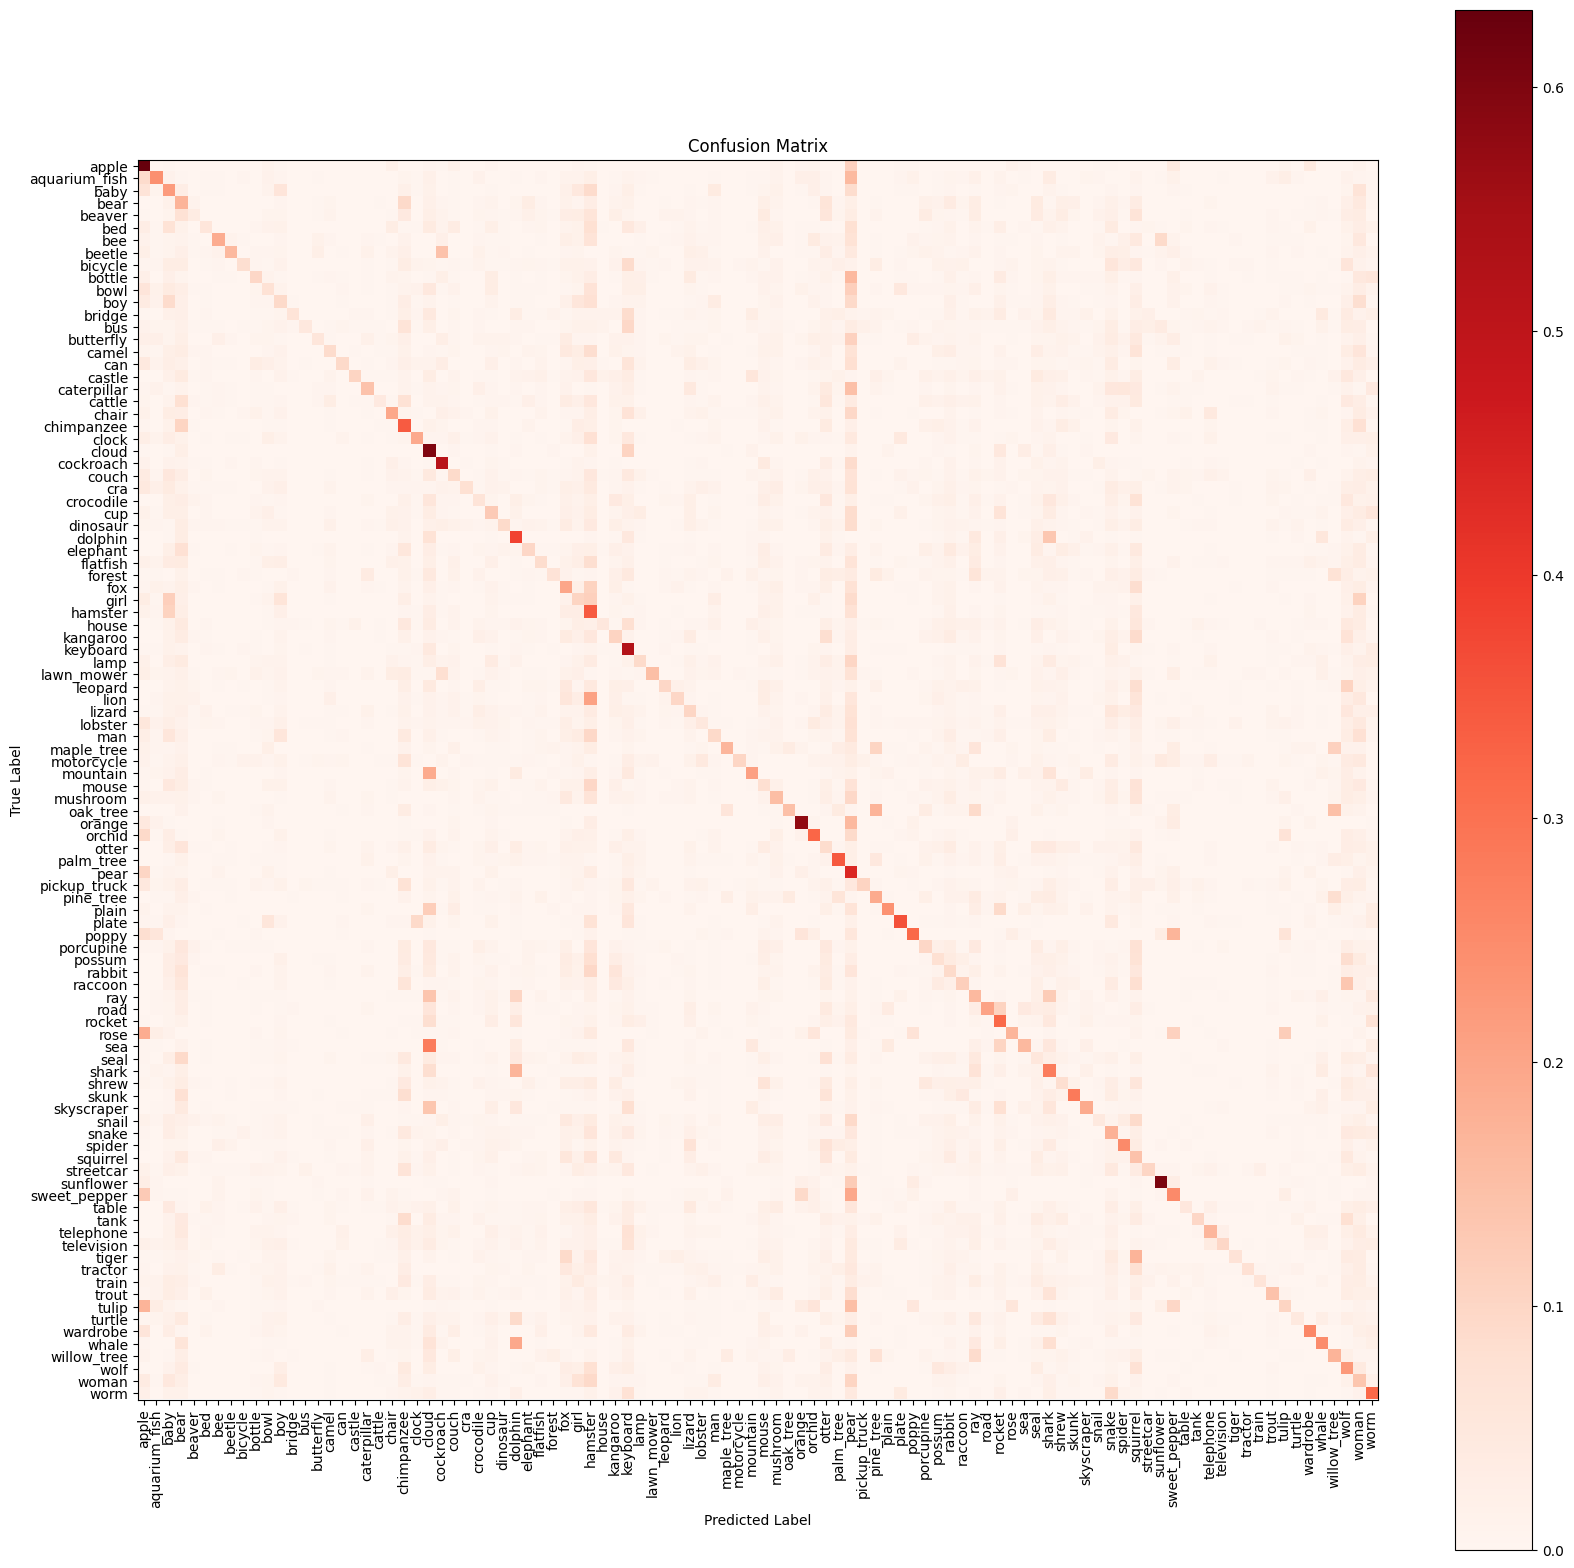

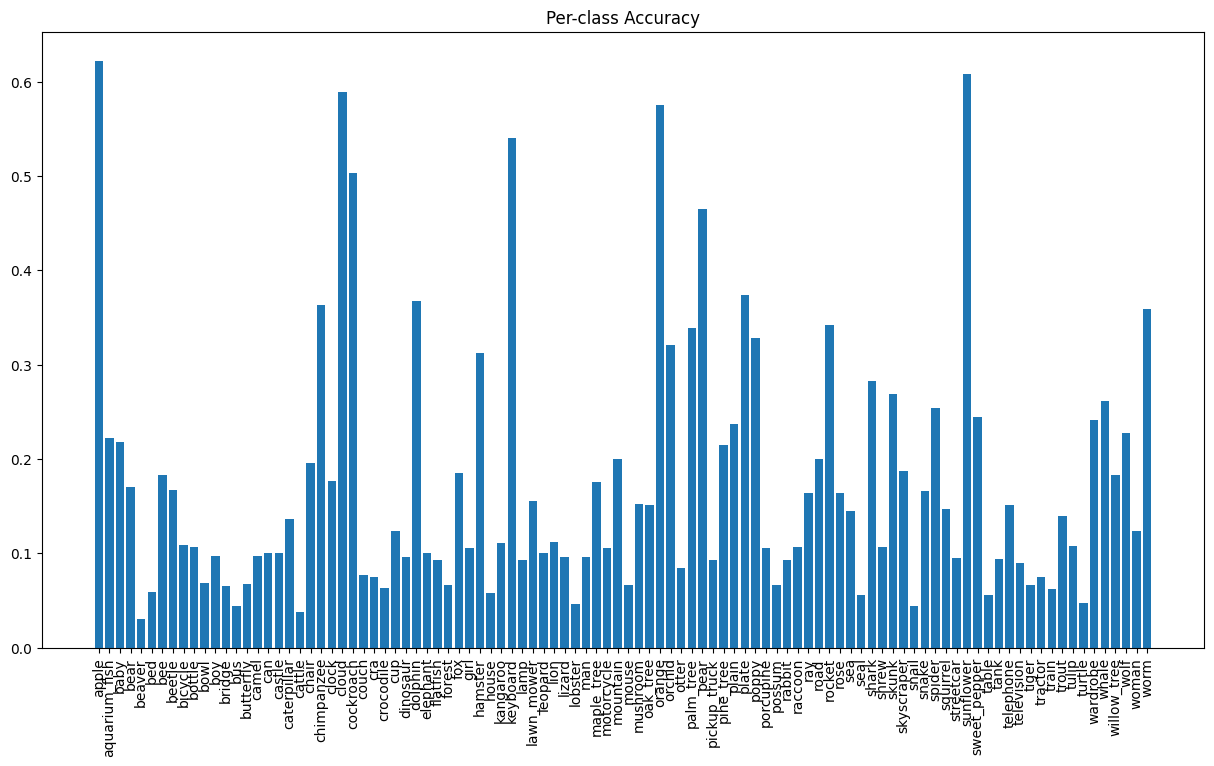

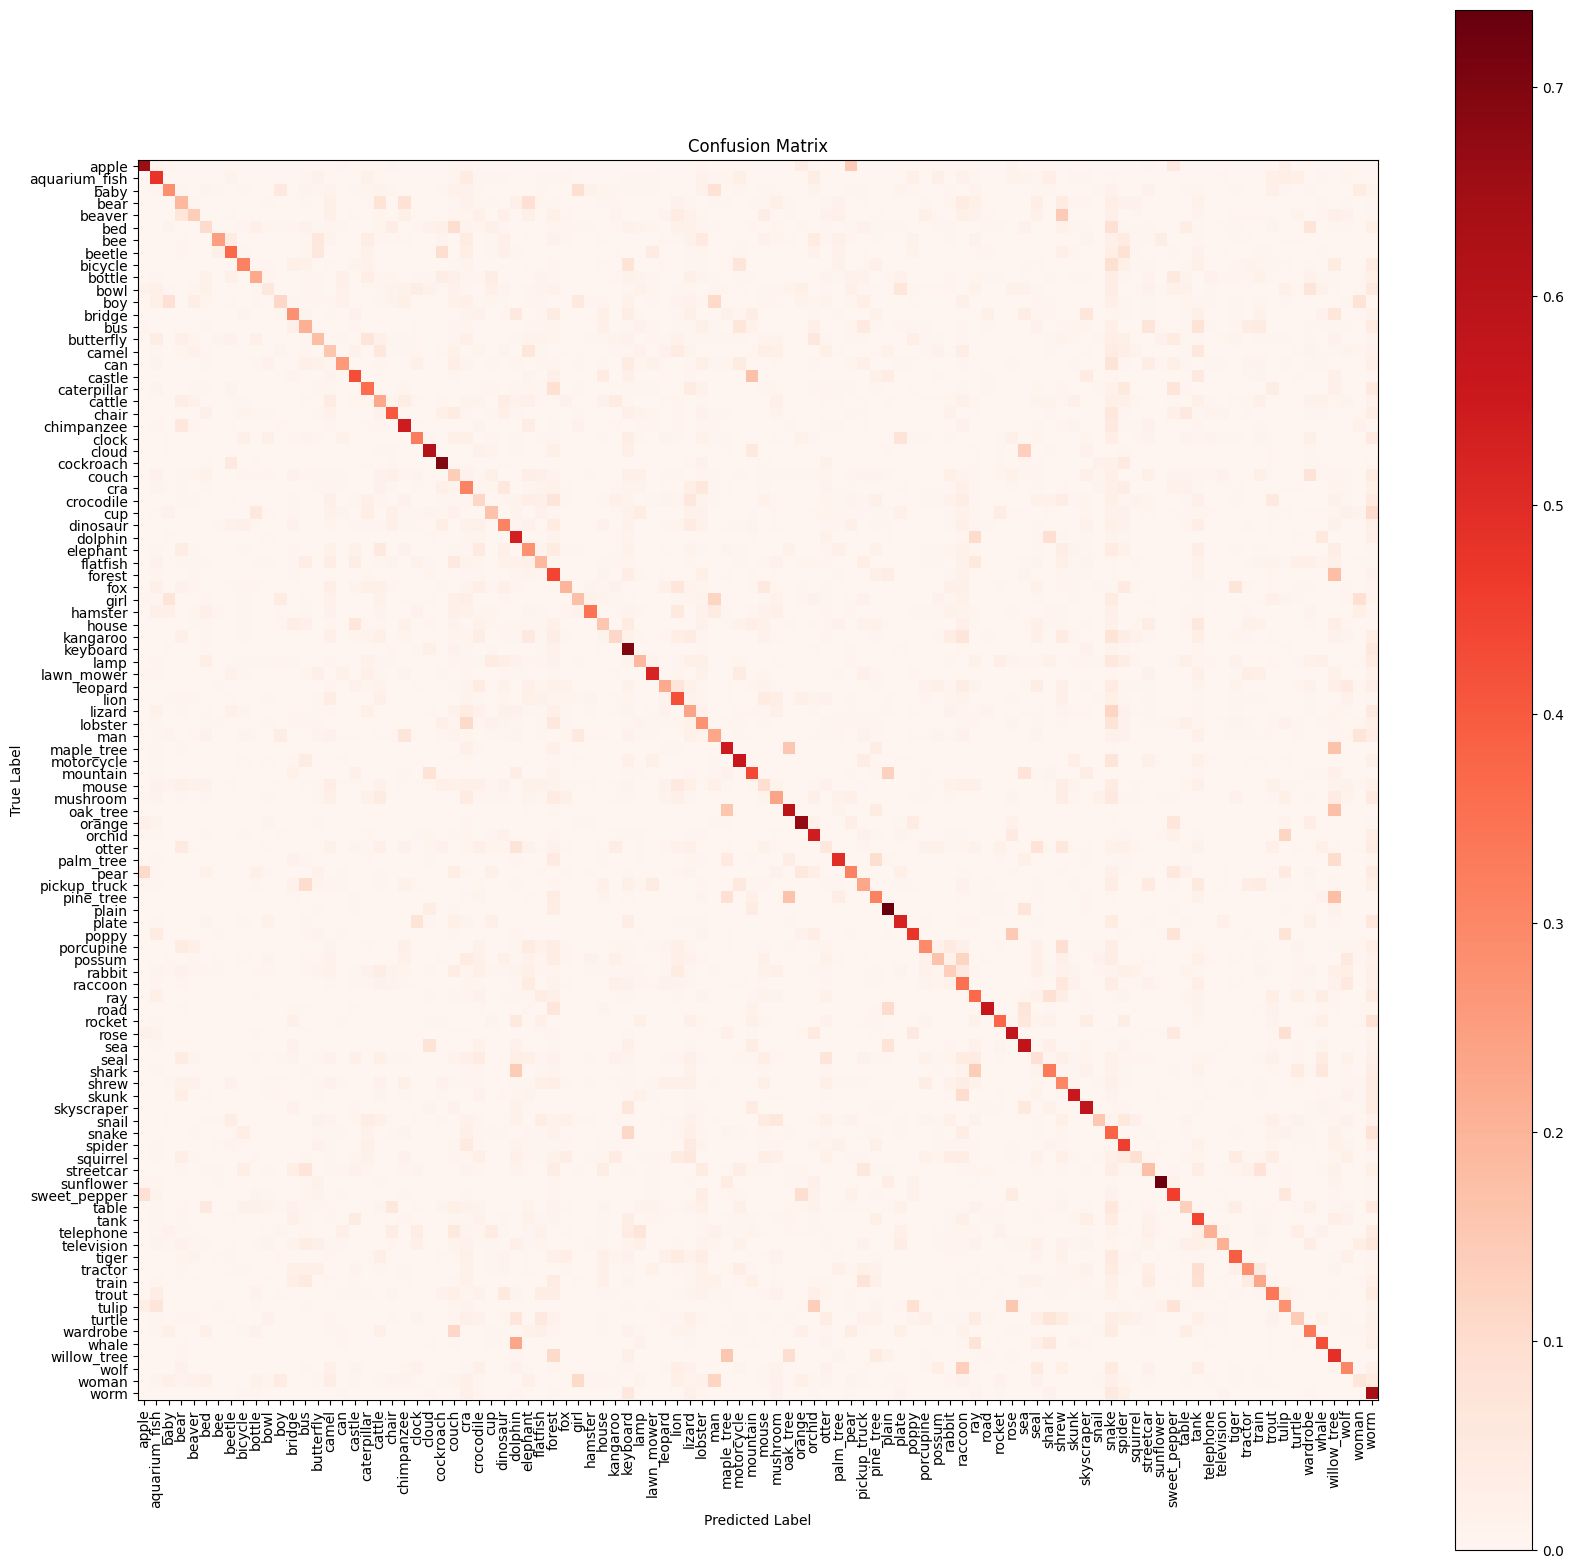

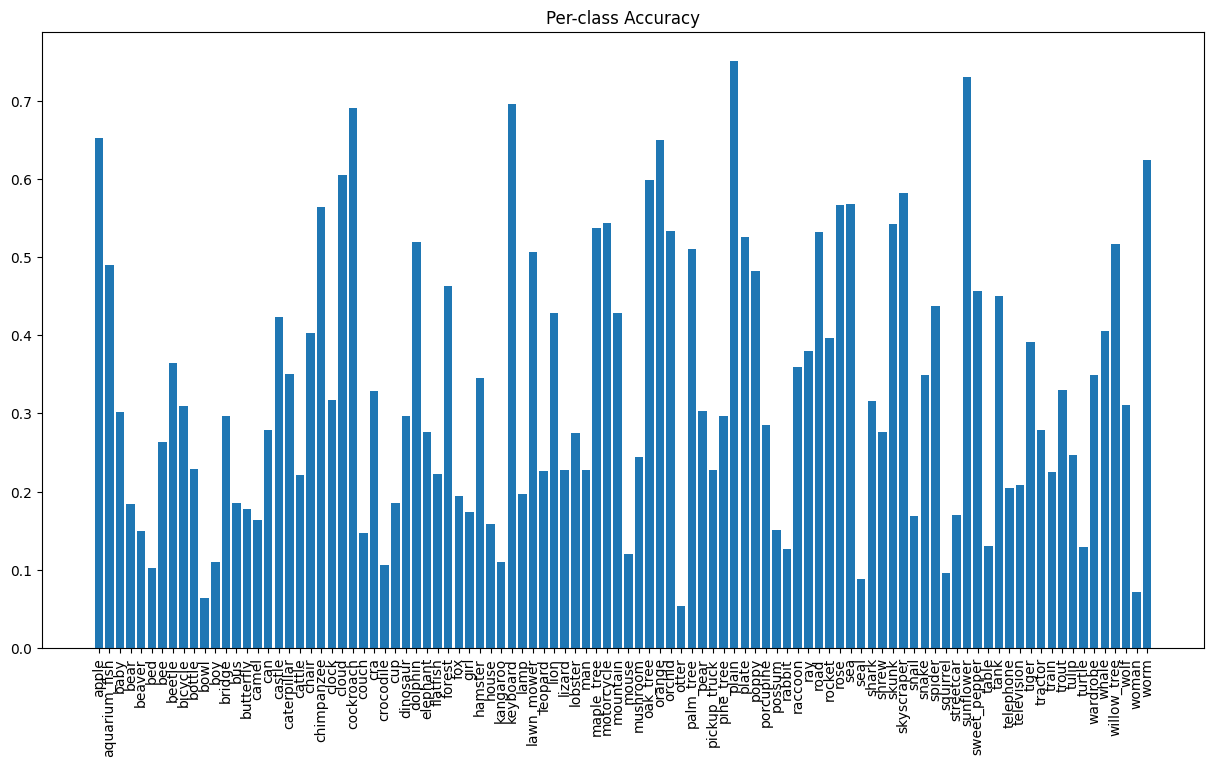

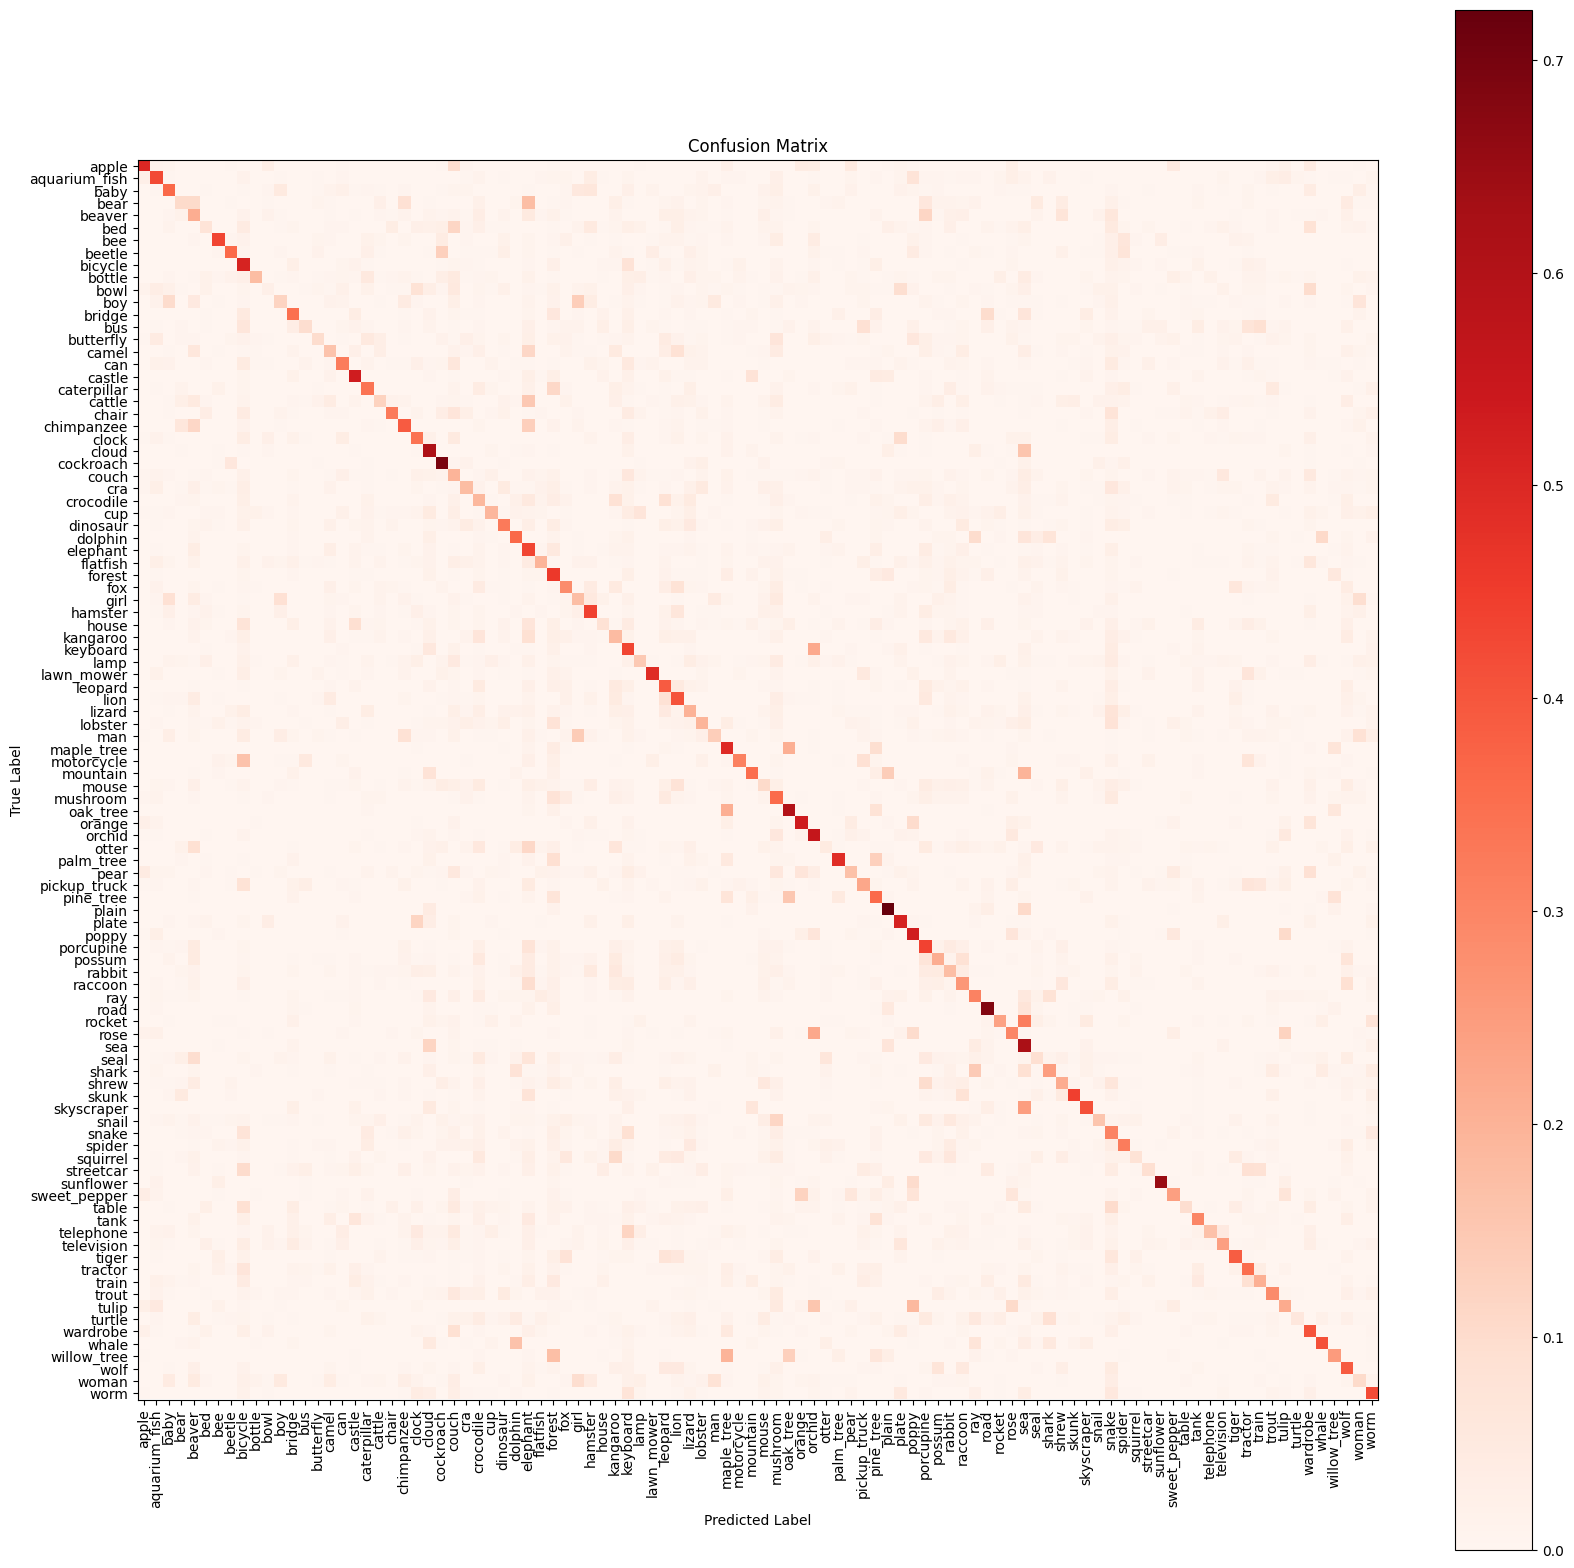

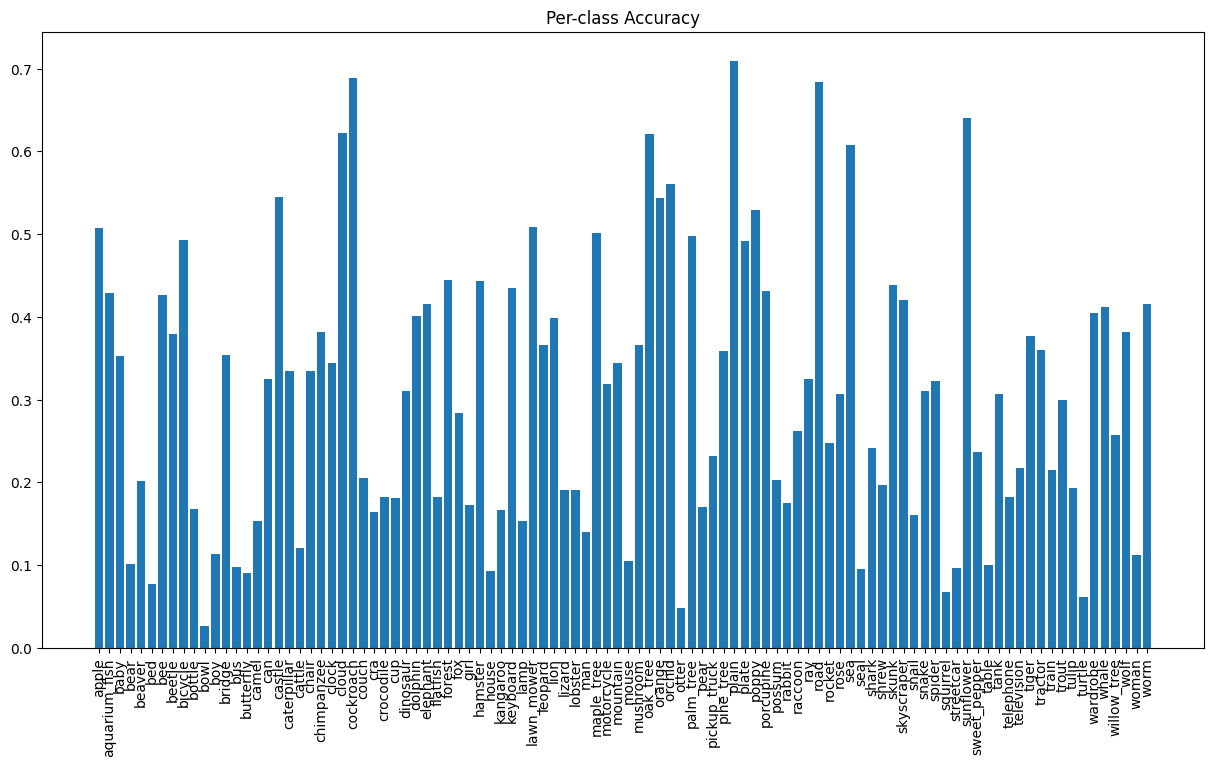

In [18]:
import gc
import os

all_model_certainties = []

try:
    os.mkdir(f'./plots')
except:
    pass

for model in all_models:
    n_transforms = 10
    cert_mean, cert_std = evaluate_certainty(model, n_transforms)

    all_model_certainties.append(cert_mean)

    print(f'Mean and Std of certainty for {model.name} after {n_transforms} pass throughs: {cert_mean}, {cert_std}')
    
    gc.collect()

    plot_confusion_matrix(model, n_transforms)

    gc.collect()

    calculate_per_class_accuracy(model, n_transforms)

    print('-------------------------------')
    gc.collect()


['Base Model', 'Aug Model', 'More Aug Model']


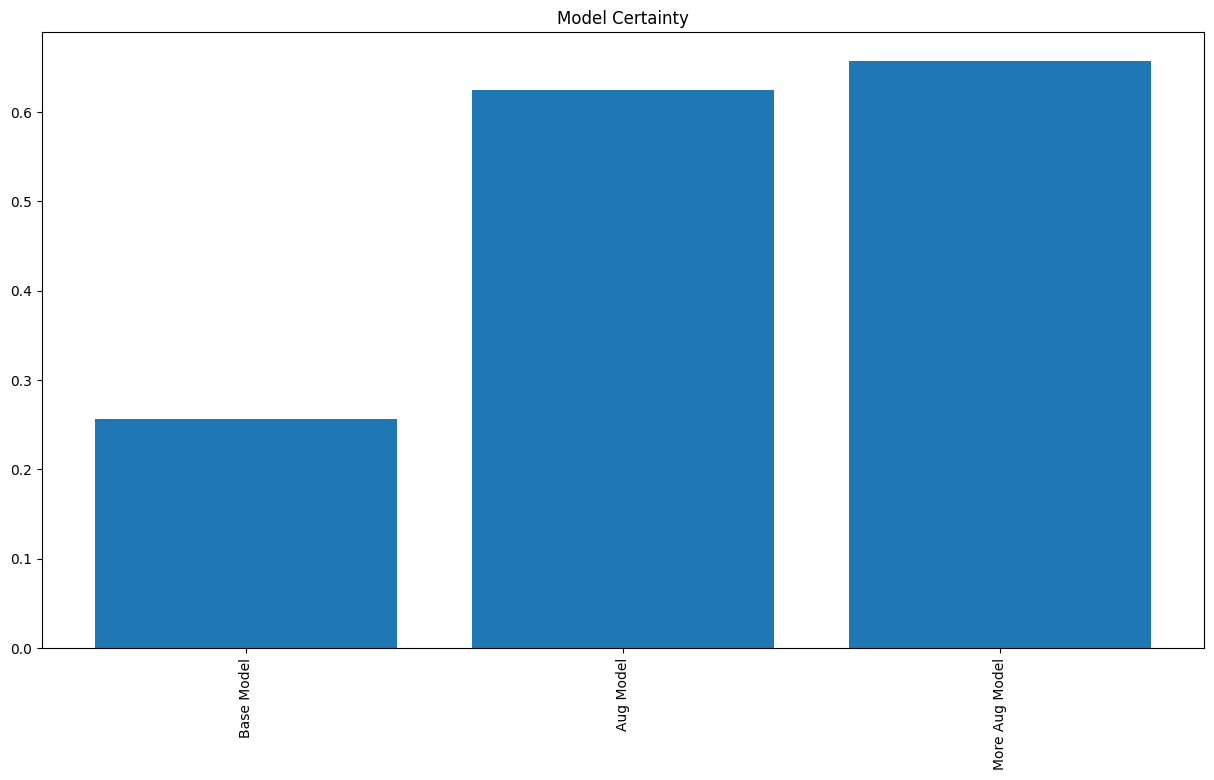

In [67]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(np.arange(len(all_models)), all_model_certainties)
ax.set_title("Model Certainties")

all_model_names = [model.name for model in all_models]
print(all_model_names)
ax.set_xticks(np.arange(len(all_models)), all_model_names, rotation='vertical')

fig.show()

plt.savefig('plots/all-model-certainties.png')


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
